# Project: Benetech - Making Graphs Accessible
## Exploratory Data Analysis (EDA)
#### https://www.kaggle.com/competitions/benetech-making-graphs-accessible/data

### Importing Libraries and Images + Json files

In [1]:
import os
import json
import glob
import PIL
import PIL.Image
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import cv2
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models
# from torchvision import transforms
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader



In [2]:
class ImageDataset:
    def __init__(self, img_dir, json_dir, transform=None):
        self.img_dir = img_dir
        self.json_dir = json_dir
        self.transform = transform
        self.data = self._load_data()

    def _load_data(self):
        # Load image and JSON file paths
        img_files = sorted(glob.glob(os.path.join(self.img_dir, '*.jpg')))
        json_files = sorted(glob.glob(os.path.join(self.json_dir, '*.json')))
        data = []
        # Iterate over each pair of image and JSON files
        for json_file, img_file in zip(json_files, img_files):
            # Load JSON data
            with open(json_file) as f:
                try:
                    json_data = json.load(f)
                except json.JSONDecodeError:
                    print(f"Error loading JSON file: {json_file}")
                    continue
                
            # Check if image file exists
            if not os.path.exists(img_file):
                print(f"Image file not found: {img_file}")
                continue

            lst = [img_file]
            for obj in json_data:
                lst.append(json_data[obj])
            data.append(lst)
        return pd.DataFrame(data, columns=['image_loc', 'source', 'chart_type', 'plot_bb', 'text', 'axes', 'visual_elements', 'data_series'])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        image_path = item['image_loc']
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image
        
    def split_dataset(self, test_size=0.3, random_state=42):
        # Split dataset into train and test sets
        train, test = train_test_split(self.data, test_size=test_size, random_state=random_state, shuffle=True)
        train['dataset'] = 'train'
        test['dataset'] = 'test'
        return train, test

    def plot_image_with_annotations(self, idx):
        # Load image
        img_path = self.data.iloc[idx]['image_loc']
        if not os.path.exists(img_path):
            print(f"Image file not found: {img_path}")
            return
        img = cv2.imread(img_path)
        if img is None:
            print(f"Error loading image: {img_path}")
            return
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Plot annotations on the image
        annotations = self.data.iloc[idx]['text']
        for text_item in annotations:
            polygon = text_item['polygon']
            text = text_item['text']
            role = text_item['role']
            x, y, w, h = polygon['x0'], polygon['y0'], polygon['x1'] - polygon['x0'], polygon['y1'] - polygon['y0']
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 0, 255), 1)
            cv2.putText(img, f'{text} ({role})', (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 1)

        # Plot y-axis ticks
        for tick in self.data.iloc[idx]['axes']['y-axis']['ticks']:
            cv2.circle(img, (tick['tick_pt']['x'], tick['tick_pt']['y']), radius=2, color=(255, 0, 255), thickness=3)

        # Plot x-axis ticks
        for tick in self.data.iloc[idx]['axes']['x-axis']['ticks']:
            cv2.circle(img, (tick['tick_pt']['x'], tick['tick_pt']['y']), radius=2, color=(255, 0, 255), thickness=3)

        # Display the image
        plt.imshow(img)
        plt.show()

    def visualize_dataset(self, num_samples=5):
        for idx in range(min(num_samples, len(self.data))):
            self.plot_image_with_annotations(idx)

    def save_dataset(self, dataset, file_path):
        # Save dataset to file_path
        dataset.to_csv(file_path, index=False)

    def split_images_by_labels(self, dataset, output_dir):
        def copy_image(row, output_dir):
            image_loc = row['image_loc']
            label = row['chart_type']
            image_name = os.path.basename(image_loc)
            output_label_dir = os.path.join(output_dir, label)
            os.makedirs(output_label_dir, exist_ok=True)
            shutil.copy(image_loc, os.path.join(output_label_dir, image_name))
    
        dataset.apply(copy_image, axis=1, output_dir=output_dir)

In [3]:
# Directories
img_dir = 'D:\\Group Project\\benetech-making-graphs-accessible\\train\\images\\'
json_dir = 'D:\\Group Project\\benetech-making-graphs-accessible\\train\\annotations\\'
train_output_dir = 'D:\\Group Project\\benetech-making-graphs-accessible\\train\\output\\'
test_output_dir = 'D:\\Group Project\\benetech-making-graphs-accessible\\test\\output\\'

In [4]:
# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:
%%time
# Create an instance of the custom dataset
dataset = ImageDataset(img_dir, json_dir, transform=transform)

CPU times: total: 34.7 s
Wall time: 3min 11s


In [6]:
len(os.listdir(img_dir))

60578

In [7]:
len(os.listdir(json_dir))

60578

In [8]:
# Split dataset
train_dataset, test_dataset = dataset.split_dataset()

# Reset the index of the train and test datasets
train_dataset.reset_index(drop=True, inplace=True)
test_dataset.reset_index(drop=True, inplace=True)

In [9]:
train_dataset.head()

,image_loc,source,chart_type,plot_bb,text,axes,visual_elements,data_series,dataset
0,D:\Group Project\benetech-making-graphs-access...,generated,scatter,"{'height': 201, 'width': 417, 'x0': 57, 'y0': 26}","[{'id': 0, 'polygon': {'x0': 18, 'x1': 47, 'x2...","{'x-axis': {'ticks': [{'id': 6, 'tick_pt': {'x...","{'bars': [], 'boxplots': [], 'dot points': [],...","[{'x': 1.069539666993145, 'y': 51.629758646429...",train
1,D:\Group Project\benetech-making-graphs-access...,generated,dot,"{'height': 207, 'width': 418, 'x0': 87, 'y0': 41}","[{'id': 0, 'polygon': {'x0': 197, 'x1': 392, '...","{'x-axis': {'ticks': [{'id': 14, 'tick_pt': {'...","{'bars': [], 'boxplots': [], 'dot points': [[{...","[{'x': '1985', 'y': 6}, {'x': '1992', 'y': 8},...",train
2,D:\Group Project\benetech-making-graphs-access...,generated,vertical_bar,"{'height': 196, 'width': 393, 'x0': 67, 'y0': 29}","[{'id': 0, 'polygon': {'x0': 5, 'x1': 31, 'x2'...","{'x-axis': {'ticks': [{'id': 14, 'tick_pt': {'...","{'bars': [{'height': 18, 'width': 6, 'x0': 76,...","[{'x': '1995', 'y': 938.4967062257425}, {'x': ...",train
3,D:\Group Project\benetech-making-graphs-access...,generated,scatter,"{'height': 186, 'width': 383, 'x0': 72, 'y0': 40}","[{'id': 0, 'polygon': {'x0': 108, 'x1': 392, '...","{'x-axis': {'ticks': [{'id': 13, 'tick_pt': {'...","{'bars': [], 'boxplots': [], 'dot points': [],...","[{'x': 1.0230040595399181, 'y': 9.800539083557...",train
4,D:\Group Project\benetech-making-graphs-access...,generated,vertical_bar,"{'height': 194, 'width': 437, 'x0': 47, 'y0': 62}","[{'id': 0, 'polygon': {'x0': 92, 'x1': 463, 'x...","{'x-axis': {'ticks': [{'id': 13, 'tick_pt': {'...","{'bars': [{'height': 183, 'width': 11, 'x0': 6...","[{'x': 'Malawi', 'y': 85.31149093727127}, {'x'...",train


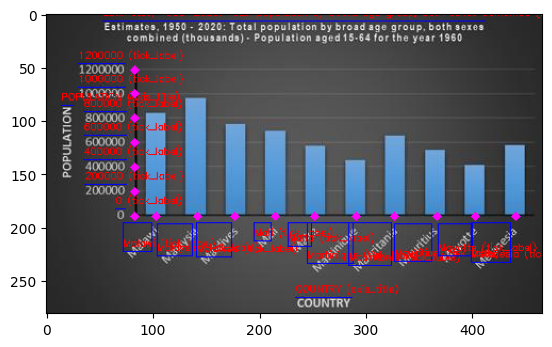

In [10]:
# Plot image with annotations for a specific index
dataset.plot_image_with_annotations(0)

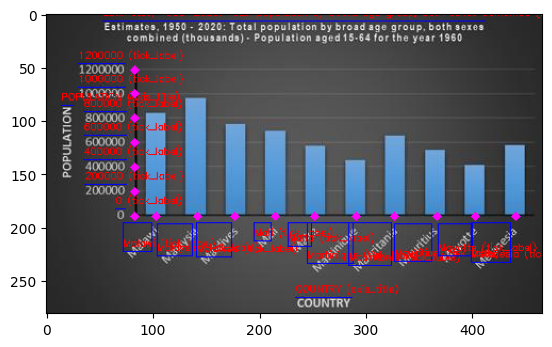

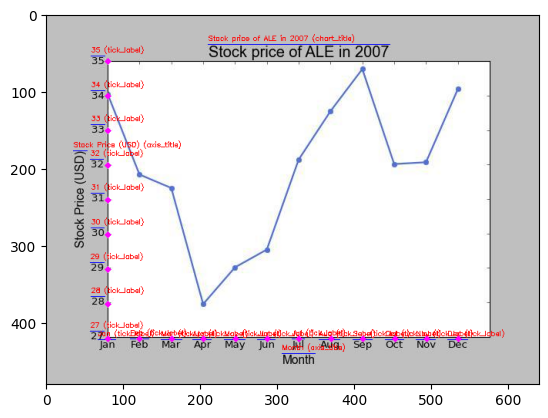

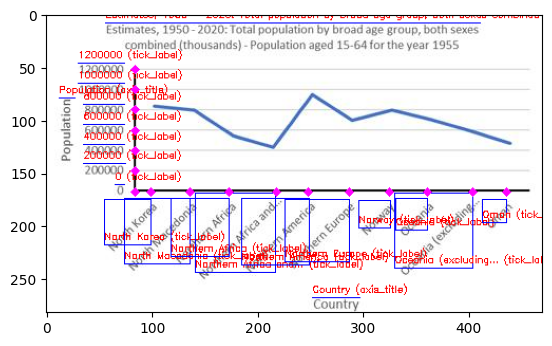

In [11]:
# Visualize the dataset
dataset.visualize_dataset(num_samples=3)

In [12]:
%%time
# Split train images
dataset.split_images_by_labels(train_dataset, train_output_dir)

CPU times: total: 44.4 s
Wall time: 2min 9s


In [13]:
%%time
# Split test images
dataset.split_images_by_labels(test_dataset, test_output_dir)

CPU times: total: 19.5 s
Wall time: 56.5 s


In [14]:
%%time
# Save the dataset
dataset.save_dataset(train_dataset, 'D:\\Group Project\\benetech-making-graphs-accessible\\train_dataset.csv')
dataset.save_dataset(test_dataset, 'D:\\Group Project\\benetech-making-graphs-accessible\\test_dataset.csv')

CPU times: total: 12.9 s
Wall time: 12.9 s


In [15]:
# Inspect the first few rows of the DataFrame
print(train_dataset.head())

                                           image_loc     source    chart_type  \
0  D:\Group Project\benetech-making-graphs-access...  generated       scatter   
1  D:\Group Project\benetech-making-graphs-access...  generated           dot   
2  D:\Group Project\benetech-making-graphs-access...  generated  vertical_bar   
3  D:\Group Project\benetech-making-graphs-access...  generated       scatter   
4  D:\Group Project\benetech-making-graphs-access...  generated  vertical_bar   

                                             plot_bb  \
0  {'height': 201, 'width': 417, 'x0': 57, 'y0': 26}   
1  {'height': 207, 'width': 418, 'x0': 87, 'y0': 41}   
2  {'height': 196, 'width': 393, 'x0': 67, 'y0': 29}   
3  {'height': 186, 'width': 383, 'x0': 72, 'y0': 40}   
4  {'height': 194, 'width': 437, 'x0': 47, 'y0': 62}   

                                                text  \
0  [{'id': 0, 'polygon': {'x0': 18, 'x1': 47, 'x2...   
1  [{'id': 0, 'polygon': {'x0': 197, 'x1': 392, '...   
2  [{'id

In [16]:
# Check the shape of the DataFrame
print(train_dataset.shape)
print(test_dataset.shape)

(42404, 9)
(18174, 9)


In [17]:
# Check for missing data
missing_data = train_dataset.isnull().sum()

# Display the missing data counts
print(missing_data)


image_loc          0
source             0
chart_type         0
plot_bb            0
text               0
axes               0
visual_elements    0
data_series        0
dataset            0
dtype: int64


## Data Encoding

### Categorical Encoding

In [18]:
train_dataset.columns

Index(['image_loc', 'source', 'chart_type', 'plot_bb', 'text', 'axes',
       'visual_elements', 'data_series', 'dataset'],
      dtype='object')

In [19]:
# Perform one-hot encoding for 'chart-type' column
encoded_chart_type_train = pd.get_dummies(train_dataset['chart_type'], prefix='chart_type')

# Convert boolean columns to numeric (0s and 1s)
encoded_chart_type_train = encoded_chart_type_train.astype(int)
                                               
# Concatenate the one-hot encoded columns with the original DataFrame
train_dataset_encoded = pd.concat([train_dataset, encoded_chart_type_train], axis=1)

# Drop the original 'chart-type' column
train_dataset_encoded.drop('chart_type', axis=1, inplace=True)

# Display the first few rows of the encoded dataset
print(train_dataset_encoded.head(3))


                                           image_loc     source  \
0  D:\Group Project\benetech-making-graphs-access...  generated   
1  D:\Group Project\benetech-making-graphs-access...  generated   
2  D:\Group Project\benetech-making-graphs-access...  generated   

                                             plot_bb  \
0  {'height': 201, 'width': 417, 'x0': 57, 'y0': 26}   
1  {'height': 207, 'width': 418, 'x0': 87, 'y0': 41}   
2  {'height': 196, 'width': 393, 'x0': 67, 'y0': 29}   

                                                text  \
0  [{'id': 0, 'polygon': {'x0': 18, 'x1': 47, 'x2...   
1  [{'id': 0, 'polygon': {'x0': 197, 'x1': 392, '...   
2  [{'id': 0, 'polygon': {'x0': 5, 'x1': 31, 'x2'...   

                                                axes  \
0  {'x-axis': {'ticks': [{'id': 6, 'tick_pt': {'x...   
1  {'x-axis': {'ticks': [{'id': 14, 'tick_pt': {'...   
2  {'x-axis': {'ticks': [{'id': 14, 'tick_pt': {'...   

                                     visual_elements  \


In [20]:
# Create a new DataFrame with 'image_loc' and one-hot encoded chart type columns
selected_columns = ['image_loc', 'chart_type_dot', 'chart_type_horizontal_bar', 'chart_type_line', 'chart_type_scatter', 'chart_type_vertical_bar']
selected_dataset_train = train_dataset_encoded[selected_columns].copy()

# Display the first few rows of the new dataset
print(selected_dataset_train.head(3))
# train_dataset_encoded = selected_dataset_train  => In new way

                                           image_loc  chart_type_dot  \
0  D:\Group Project\benetech-making-graphs-access...               0   
1  D:\Group Project\benetech-making-graphs-access...               1   
2  D:\Group Project\benetech-making-graphs-access...               0   

   chart_type_horizontal_bar  chart_type_line  chart_type_scatter  \
0                          0                0                   1   
1                          0                0                   0   
2                          0                0                   0   

   chart_type_vertical_bar  
0                        0  
1                        0  
2                        1  


In [21]:
# Perform one-hot encoding for 'chart-type' column in the test dataset
encoded_chart_type_test = pd.get_dummies(test_dataset['chart_type'], prefix='chart_type')

# Convert boolean columns to numeric (0s and 1s)
encoded_chart_type_test = encoded_chart_type_test.astype(int)

# Concatenate the one-hot encoded columns with the original DataFrame
test_dataset_encoded = pd.concat([test_dataset, encoded_chart_type_test], axis=1)

# Drop the original 'chart-type' column
test_dataset_encoded.drop('chart_type', axis=1, inplace=True)

# Display the first few rows of the encoded test dataset
print(test_dataset_encoded.head(3))


                                           image_loc     source  \
0  D:\Group Project\benetech-making-graphs-access...  generated   
1  D:\Group Project\benetech-making-graphs-access...  generated   
2  D:\Group Project\benetech-making-graphs-access...  generated   

                                             plot_bb  \
0  {'height': 131, 'width': 384, 'x0': 77, 'y0': 44}   
1  {'height': 167, 'width': 393, 'x0': 84, 'y0': 67}   
2  {'height': 182, 'width': 443, 'x0': 56, 'y0': 23}   

                                                text  \
0  [{'id': 0, 'polygon': {'x0': 66, 'x1': 424, 'x...   
1  [{'id': 0, 'polygon': {'x0': 79, 'x1': 473, 'x...   
2  [{'id': 0, 'polygon': {'x0': 78, 'x1': 422, 'x...   

                                                axes  \
0  {'x-axis': {'ticks': [{'id': 13, 'tick_pt': {'...   
1  {'x-axis': {'ticks': [{'id': 10, 'tick_pt': {'...   
2  {'x-axis': {'ticks': [{'id': 12, 'tick_pt': {'...   

                                     visual_elements  \


In [22]:
# Create a new DataFrame with 'image_loc' and one-hot encoded chart type columns
selected_columns = ['image_loc', 'chart_type_dot', 'chart_type_horizontal_bar', 'chart_type_line', 'chart_type_scatter', 'chart_type_vertical_bar']
selected_dataset_test = test_dataset_encoded[selected_columns].copy()

# Display the first few rows of the new dataset
print(selected_dataset_test.head(3))
# test_dataset_encoded = selected_dataset_test  => In new way

                                           image_loc  chart_type_dot  \
0  D:\Group Project\benetech-making-graphs-access...               0   
1  D:\Group Project\benetech-making-graphs-access...               0   
2  D:\Group Project\benetech-making-graphs-access...               0   

   chart_type_horizontal_bar  chart_type_line  chart_type_scatter  \
0                          0                0                   0   
1                          0                0                   1   
2                          0                1                   0   

   chart_type_vertical_bar  
0                        1  
1                        0  
2                        0  


In [23]:
# Check data types
print(selected_dataset_train.dtypes)

image_loc                    object
chart_type_dot                int32
chart_type_horizontal_bar     int32
chart_type_line               int32
chart_type_scatter            int32
chart_type_vertical_bar       int32
dtype: object


In [24]:
# Define the device for training (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [25]:
# Define our CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 56 * 56, 256)
        self.fc2 = nn.Linear(256, 5)  # Assuming 5 classes for chart types

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 32 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [26]:
# Define our model, loss function, and optimizer
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [27]:
%%time
# Training loop
epochs = 5
losses = []
accuracies = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    running_loss = 0.0
    total = 0
    correct = 0
    for i in range(len(selected_dataset_train)):
        # Get the image and its label
        image_path = selected_dataset_train.iloc[i]['image_loc']
        label = selected_dataset_train.iloc[i][['chart_type_dot', 'chart_type_horizontal_bar', 'chart_type_line', 'chart_type_scatter', 'chart_type_vertical_bar']].values
        label = label.astype(int)  # Convert label to integers
        image = Image.open(image_path).convert('RGB')
        image = transform(image).unsqueeze(0).to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(image)
        
        # Ensure label has the same batch size as outputs
        batch_size = outputs.size(0)
        label_tensor = torch.tensor(label)[:batch_size].to(device).long()  # Convert to Long

        loss = criterion(outputs, label_tensor)
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += label_tensor.size(0)
        correct += (predicted == label_tensor).sum().item()

        # Print statistics
        running_loss += loss.item()
        if i % 1000 == 999:  # Print every 1000 mini-batches
            accuracy = correct / total
            accuracies.append(accuracy)
            print('[%d, %5d] loss: %.3f, accuracy: %.3f' % (epoch + 1, i + 1, running_loss / 1000, accuracy))
            losses.append(running_loss / 1000)
            running_loss = 0.0


Epoch 1/5
[1,  1000] loss: 0.433, accuracy: 0.874
[1,  2000] loss: 0.177, accuracy: 0.899
[1,  3000] loss: 0.139, accuracy: 0.917
[1,  4000] loss: 0.154, accuracy: 0.926
[1,  5000] loss: 0.130, accuracy: 0.933
[1,  6000] loss: 0.087, accuracy: 0.940
[1,  7000] loss: 0.089, accuracy: 0.945
[1,  8000] loss: 0.067, accuracy: 0.949
[1,  9000] loss: 0.072, accuracy: 0.952
[1, 10000] loss: 0.119, accuracy: 0.954
[1, 11000] loss: 0.045, accuracy: 0.957
[1, 12000] loss: 0.091, accuracy: 0.959
[1, 13000] loss: 0.078, accuracy: 0.961
[1, 14000] loss: 0.064, accuracy: 0.962
[1, 15000] loss: 0.153, accuracy: 0.963
[1, 16000] loss: 0.067, accuracy: 0.965
[1, 17000] loss: 0.110, accuracy: 0.965
[1, 18000] loss: 0.048, accuracy: 0.966
[1, 19000] loss: 0.057, accuracy: 0.968
[1, 20000] loss: 0.054, accuracy: 0.968
[1, 21000] loss: 0.035, accuracy: 0.969
[1, 22000] loss: 0.051, accuracy: 0.970
[1, 23000] loss: 0.476, accuracy: 0.971
[1, 24000] loss: 0.082, accuracy: 0.971
[1, 25000] loss: 0.048, accura

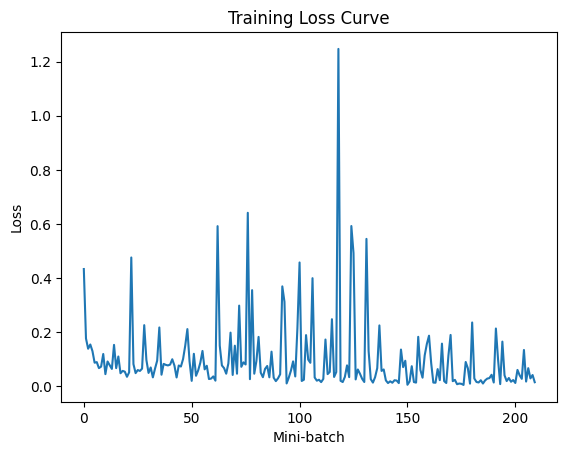

In [28]:
# Plotting the loss curve
plt.figure()
plt.plot(losses)
plt.xlabel('Mini-batch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

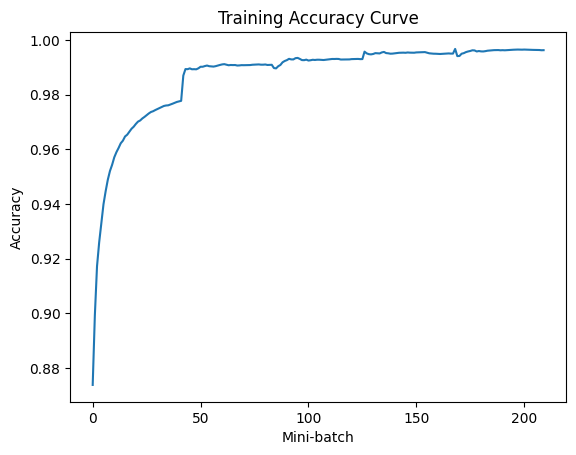

In [29]:
# Plotting the accuracy curve
plt.figure()
plt.plot(accuracies)
plt.xlabel('Mini-batch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Curve')
plt.show()

In [30]:
# Testing loop
correct = 0
total = 0
with torch.no_grad():
    for i in range(len(selected_dataset_test)):
        image_path = selected_dataset_test.iloc[i]['image_loc']
        label = selected_dataset_test.iloc[i][['chart_type_dot', 'chart_type_horizontal_bar', 'chart_type_line', 'chart_type_scatter', 'chart_type_vertical_bar']].values
        label = label.astype(int)  # Convert label to integers
        image = Image.open(image_path).convert('RGB')
        image = transform(image).unsqueeze(0).to(device)

        outputs = model(image)
        _, predicted = torch.max(outputs.data, 1)
        total += 1
        label_tensor = torch.tensor(label)[:predicted.size(0)].to(device)
        if (predicted == label_tensor).all():
            correct += 1

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))


Accuracy of the network on the test images: 97 %


# Unseen Data (Images)

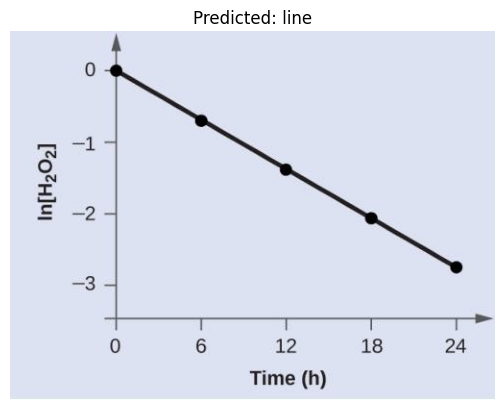

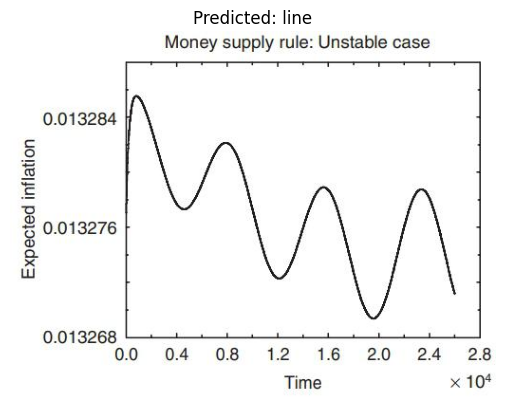

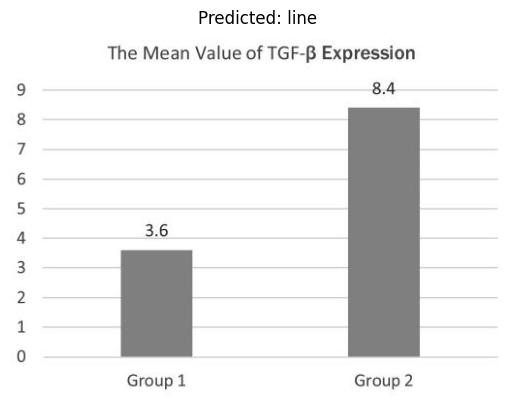

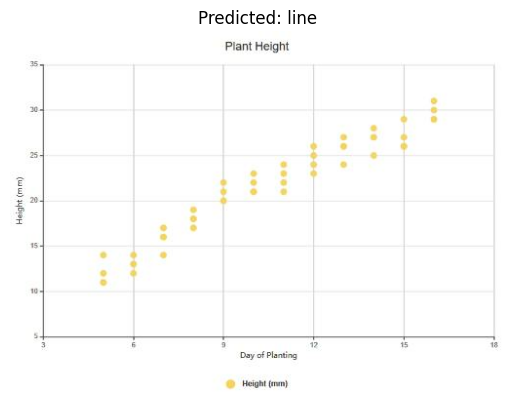

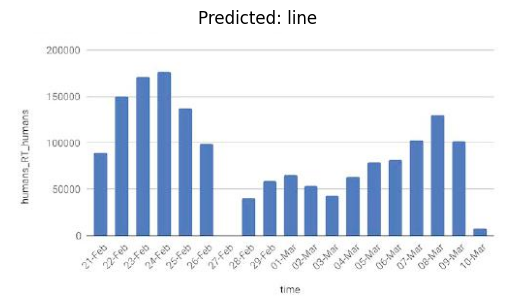

In [40]:
class_names = ['line', 'vertical_bar', 'scatter', 'dot', 'horizontal_bar']
# class_names = ['chart_type_line', 'chart_type_vertical_bar', 'chart_type_scatter', 'chart_type_dot', 'chart_type_horizontal_bar']

# Define the path to your images
image_folder_path_test = r'D:\\Group Project\\benetech-making-graphs-accessible\\test\\images\\'
image_paths_test = [os.path.join(image_folder_path_test, image_name) for image_name in os.listdir(image_folder_path_test)]

# Load and preprocess new images
new_images = [Image.open(image_path).convert('RGB') for image_path in image_paths_test]
preprocessed_images = [transform(image).unsqueeze(0) for image in new_images]

# Pass the preprocessed images through your model
with torch.no_grad():
    for image, image_path in zip(preprocessed_images, image_paths_test):
        output = model(image.to(device))
        _, predicted = torch.max(output, dim=1)
        predicted_label = class_names[predicted[0].item()]  # Assuming class_names is a list of human-readable class names
        # Display the image along with the predicted label
        plt.imshow(Image.open(image_path))
        plt.title(f'Predicted: {predicted_label}')
        plt.axis('off')
        plt.show()
